# Siberia March-May temperature anomalies
Seasonal average temperatures broken records were broken across Siberia in March-May 2020. Here we plot the region where ERA5 records were broken.

In this first section, we load required packages and modules

In [2]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [3]:
##import packages

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from shapely import geometry


#for rank calculation
import bottleneck

In [4]:
## this is to load our own function to retrieve ERA5,
## which is located in ../../src/CDSretrieve.py
import os
import sys

sys.path.insert(0, os.path.abspath('../../'))
os.chdir(os.path.abspath('../../'))
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

In [5]:
##And here we load the module
import src.cdsretrieve as retrieve
import src.preprocess as preprocess

## Download ERA5

This section describes the retrieval of ERA5.
We retrieve netcdf files of global monthly 2m temperature and 2m dewpoint temperature for each year over 1979-2020. 
The data were retrieved in August 2020.

In [ ]:
retrieve.retrieve_ERA5(variables = ['2m_temperature','2m_dewpoint_temperature'], folder = '../Siberia_example/')
;

We load all files with xarray `open_mfdataset`. The latest 3 months in this dataset are made available through ERA5T, which might be slightly different to ERA5.
In the downloaded file, an extra dimenions 'expver' indicates which data is ERA5 (`expver = 1`) and which is ERA5T (`expver = 5`). 
After retrieving and loading, I combine both ERA5 and ERA5T to create a dataset that runs until August 2020.


In [6]:
ERA5 = xr.open_mfdataset('../Siberia_example/ERA5_????.nc',combine='by_coords') ## open the data
ERA5# 

,Array,Chunk
Bytes,260.64 MB,6.26 MB
Shape,"(500, 181, 360, 2)","(12, 181, 360, 2)"
Count,209 Tasks,42 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,260.64 MB,6.26 MB
Shape,"(500, 181, 360, 2)","(12, 181, 360, 2)"
Count,209 Tasks,42 Chunks
Type,float32,numpy.ndarray


In [7]:
ERA5_combine =ERA5.sel(expver=1).combine_first(ERA5.sel(expver=5))
ERA5_combine.load()

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 500)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-08-01
Data variables:
    t2m        (time, latitude, longitude) float32 244.7074 ... 214.79857
    d2m        (time, latitude, longitude) float32 241.76836 ... 211.0198
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-07 10:14:42 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [8]:
month_length = ERA5_combine.time.dt.days_in_month
ERA5_seasonal = ((ERA5_combine * month_length).resample(time='QS-DEC').sum() / 
          month_length.resample(time='QS-DEC').sum())
ERA5_seasonal

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 167)
Coordinates:
  * time       (time) datetime64[ns] 1978-12-01 1979-03-01 ... 2020-06-01
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
Data variables:
    t2m        (time, latitude, longitude) float64 243.2 243.2 ... 218.9 218.9
    d2m        (time, latitude, longitude) float64 240.1 240.1 ... 215.2 215.2

## Calculating the rank

We want to show for each month whether the recorded monthly average temperature for 2020 is the highest since 1979 (or second highest, etc.). 

We first select only January months.

In [9]:
ERA5_MAM = ERA5_seasonal.sel(time=ERA5_seasonal['time.month'] == 3) ## Select only for MAM

Then we calculate the rank of January average temperatures over the years. We rename the variable 't2m' into 'Temperature rank'. 

In [10]:
ERA5_MAM_rank = ERA5_MAM['t2m'].rank(dim = 'time')
ERA5_MAM_rank = ERA5_MAM_rank.rename('Temperature rank')

We now have calculated the rank in increasing order, i.e. the highest values has the highest rank. 
However, we want to show the highest rank being number 1, the second highest being number 2. Therefore, we invert the ranks 
and then we select the inverted rank of January 2020 average temperature within the January average temperatures of the other years. If January 2020 average temperature would be highest on record, the inverted rank will be 1. Second highest will be 2.

In [11]:
ERA5_MAM_rank_inverted = (len(ERA5_MAM_rank.time) - ERA5_MAM_rank + 1).sel(time='2020')
ERA5_MAM_rank_inverted

<xarray.DataArray 'Temperature rank' (time: 1, latitude: 181, longitude: 360)>
array([[[17., 17., 17., ..., 17., 17., 17.],
        [15., 15., 15., ..., 14., 14., 14.],
        [13., 13., 15., ..., 13., 13., 13.],
        ...,
        [12., 12., 12., ..., 11., 11., 12.],
        [ 6.,  6.,  6., ...,  6.,  6.,  6.],
        [ 3.,  3.,  3., ...,  3.,  3.,  3.]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-03-01
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0

## Plotting

We define a function to plot the data on a global map:

In [12]:
def Global_plot(ERA5_i_rank_inverted):
    fig, ax = plt.subplots(frameon=False, figsize=(90 / 25.4, 60 / 25.4))
    ax = plt.axes(projection=ccrs.Robinson())
    ERA5_i_rank_inverted.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[1, 2, 3, 4, 5],
        extend='both',
        colors=plt.cm.Reds_r)

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(
        resolution='110m')  #Currently can be one of “110m”, “50m”, and “10m”.
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
    geom = geometry.box(minx=65, # the domain we select
                        maxx=120,
                        miny=50,
                        maxy=70)
    ax.add_geometries([geom],
                      crs=cartopy.crs.PlateCarree(),
                      linewidth=3,
                      facecolor='none',
                      edgecolor='black')

And plot!

In [13]:
### Set extent and projection
plt.rcParams["font.family"] = "sans-serif" ##change font
plt.rcParams['font.size'] = 10  ## change font size
plt.rcParams['svg.fonttype'] = 'none' ## so inkscape recognized texts in svg file
plt.rcParams['pdf.fonttype'] = 42 ## so illustrator can recognize text

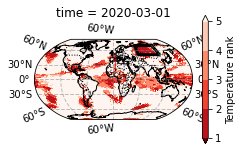

In [14]:
Global_plot(ERA5_MAM_rank_inverted)
# plt.savefig('graphs/Siberia_temprank.pdf')

And zoom in for Siberia. We define a new plot:

In [15]:
def Siberia_plot(ERA5_i_rank_inverted):
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=50.0))
    ERA5_i_rank_inverted.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=[1, 2, 3, 4, 5],
        extend='both',
        colors=plt.cm.Reds_r)

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=1,
                      color='gray',
                      alpha=0.5,
                      linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    geom = geometry.box(minx=65, # the domain we select
                        maxx=120,
                        miny=50,
                        maxy=70)
    ax.add_geometries([geom],
                      crs=cartopy.crs.PlateCarree(),
                      linewidth=3,
                      facecolor='none',
                      edgecolor='black')

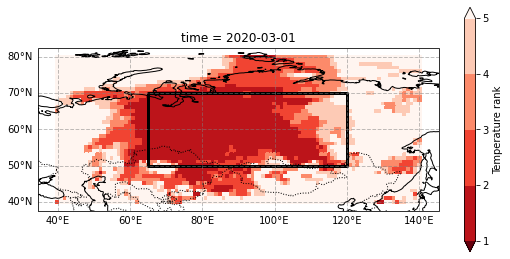

In [16]:
Siberia_plot(ERA5_MAM_rank_inverted.sel(longitude = slice(40,140), latitude = slice(80,40)))
# plt.savefig('graphs/Siberia_temprank_zoomed.pdf')

### plot the timeseries


In [20]:
ERA5_anomaly = ERA5_MAM['t2m'] - ERA5_MAM['t2m'].sel(time=slice('1979','2010')).mean('time')
ERA5_anomaly.attrs = {
    'long_name': 'August temperature anomaly',
    'units': 'C'
}
ERA5_sd_anomaly = ERA5_anomaly / ERA5_MAM['t2m'].sel(time=slice('1979','2010')).std('time')
ERA5_sd_anomaly.attrs = {
    'long_name': 'August temperature standardized anomaly',
    'units': '-'
}

In [29]:
area_weights_ERA = np.cos(np.deg2rad(ERA5_sd_anomaly.latitude))

ERA5_Siberia_events = (
    ERA5_sd_anomaly.sel(  # Select 2 metre temperature
        latitude=slice(70, 50),        # Select the latitudes
        longitude=slice(65, 120)).    # Select the longitude
    weighted(area_weights_ERA).       # weights 
    mean(['longitude', 'latitude']))  # Take the average

<Figure size 255.118x170.079 with 0 Axes>

Text(0, 0.5, 'MAM standardized anomaly')

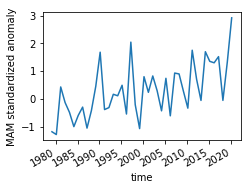

In [33]:
plt.figure(frameon=False, figsize=(90 / 25.4, 60 / 25.4))
ERA5_Siberia_events.plot()
plt.ylabel('MAM standardized anomaly')
# plt.savefig('graphs/Siberia_anomaly_timeseries.pdf', bbox_layout = 'tight')